In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

tfds.disable_progress_bar()
AUTOTUNE = tf.data.experimental.AUTOTUNE

## Setup input pipeline

In [2]:
dataset, metadata = tfds.load('cycle_gan/horse2zebra', with_info=True, as_supervised=True)

In [3]:
train_horses, train_zebras = dataset['trainA'], dataset['trainB']
test_horses, test_zebras = dataset['testA'], dataset['testB']

In [4]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [5]:
def random_jitter(image):
    # resize to 286 x 286 x 3
    image = tf.image.resize(image, [286, 286], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # randomly cropping to 256 x 256 x 3
    image = tf.image.random_crop(image, [IMG_HEIGHT, IMG_WIDTH, 3])
    # randomly mirroring
    image = tf.image.random_flip_left_right(image)
    return image

In [6]:
def preprocess_image_train(image, label):
    image = random_jitter(image)
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1 # normalize to [-1, 1]
    return image

In [7]:
def preprocess_image_test(image, label):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1 # normalize to [-1, 1]
    return image

In [8]:
train_horses = (train_horses.map(preprocess_image_train, num_parallel_calls=AUTOTUNE)
                .cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE))

train_zebras = (train_zebras.map(preprocess_image_train, num_parallel_calls=AUTOTUNE)
                .cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE))

test_horses = (test_horses.map(preprocess_image_test, num_parallel_calls=AUTOTUNE)
               .cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE))

test_zebras = (test_zebras.map(preprocess_image_test, num_parallel_calls=AUTOTUNE)
               .cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE))

In [9]:
sample_horse = next(iter(train_horses))
sample_zebra = next(iter(train_zebras))

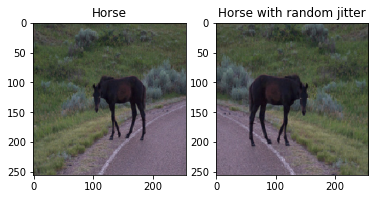

In [10]:
plt.subplot(121)
plt.title('Horse')
plt.imshow(sample_horse[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Horse with random jitter')
plt.imshow(random_jitter(sample_horse[0]) * 0.5 + 0.5)

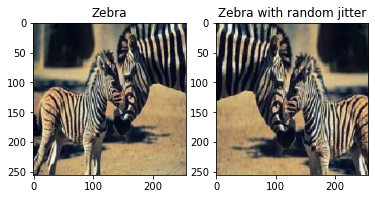

In [11]:
plt.subplot(121)
plt.title('Zebra')
plt.imshow(sample_zebra[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Zebra with random jitter')
plt.imshow(random_jitter(sample_zebra[0]) * 0.5 + 0.5)

## Import and reuse the Pix2Pix models

The model architecture used in this tutorial is very similar to what was used in pix2pix. Some of the differences are:

- Cyclegan uses instance normalization instead of `batch normalization`.
- The CycleGAN paper uses a modified `resnet` based generator. This tutorial is using a modified unet generator for simplicity.

There are 2 generators (G and F) and 2 discriminators (X and Y) being trained here.

- Generator G learns to transform image X to image Y. $(G: X -> Y)$
- Generator F learns to transform image Y to image X. $(F: Y -> X)$
- Discriminator D_X learns to differentiate between image X and generated image X (F(Y)).
- Discriminator D_Y learns to differentiate between image Y and generated image Y (G(X)).

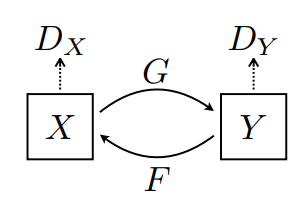

In [12]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

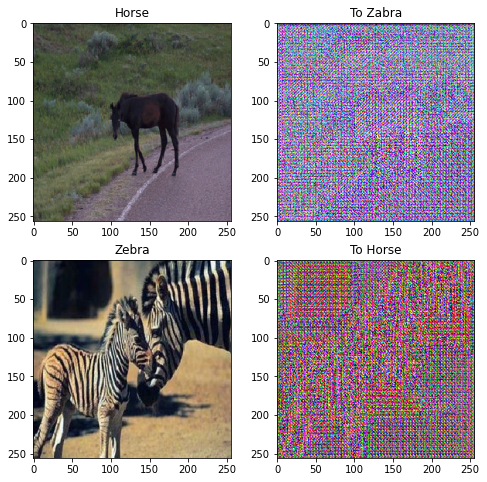

In [13]:
to_zebra = generator_g(sample_horse)
to_horse = generator_f(sample_zebra)
plt.figure(figsize=(8,8))
contrast = 8

imgs = [sample_horse, to_zebra, sample_zebra, to_horse]
title = ['Horse', 'To Zabra', 'Zebra', 'To Horse']

for i in range(len(imgs)):
    plt.subplot(2,2,i+1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
    else:
        plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

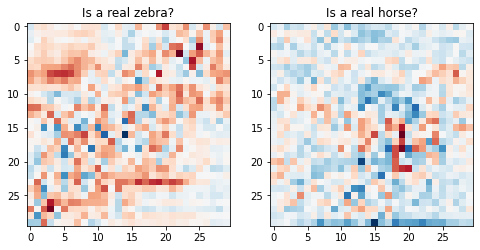

In [14]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real zebra?')
plt.imshow(discriminator_y(sample_zebra)[0, ..., 0], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real horse?')
plt.imshow(discriminator_x(sample_horse)[0, ..., 0], cmap='RdBu_r')

plt.show()

## Loss functions

In CycleGAN, there is no paired data to train on, hence there is no guarantee that the input x and the target y pair are meaningful during training. Thus in order to enforce that the network learns the correct mapping, the authors propose the cycle consistency loss.

In [15]:
LAMBDA = 10

In [16]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [17]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

In [18]:
def generator_loss(disc_generated_output):
    return loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

Cycle consistency means the result should be close to the original input. For example, if one translates a sentence from English to French, and then translates it back from French to English, then the resulting sentence should be the same as the original sentence.

In cycle consistency loss,

- Image $X$ is passed via generator $G$ that yields generated image $\hat{Y}$
- Generated image $\hat{Y}$ is passed via generator $F$ that yields cycled image $\hat{X}$
- Mean absolute error is calculated between $X$ and $\hat{X}$

$$
forward\ cycle\ consistency\ loss: X -> G(X) -> F(G(X)) \sim \hat{X}\\
backward\ cycle\ consistency\ loss: Y -> F(Y) -> G(F(X)) \sim \hat{Y}
$$

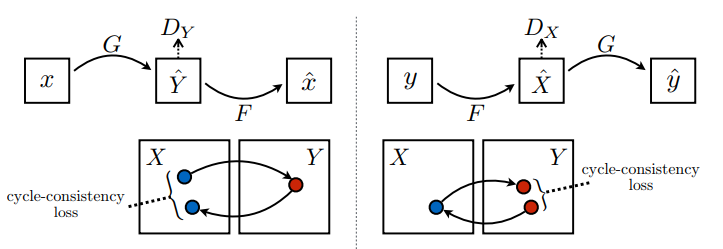

In [19]:
def cycle_loss(real_image, cycled_image):
    return tf.reduce_mean(tf.abs(real_image - cycled_image)) * LAMBDA

As shown above, generator $G$ is responsible for translating image $X$ to image $Y$. Identity loss says that, if you fed image $Y$ to generator $G$, it should yield the real image $Y$ or something close to image $Y$.

$$
identity\ loss = |G(Y) - Y| + |F(X) - X|
$$

In [20]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

In [21]:
# Initialize the optimizers for all the generators and the discriminators
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Checkpoints

In [22]:
checkpoint_dir = './checkpoints/train'
ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_dir, max_to_keep=5)

# if a checkpoint exists, restore the lastest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

## Training

In [23]:
EPOCHS = 20

In [24]:
def generate_image(generator, test_input):
    generated_image = generator(test_input)
    
    plt.figure(figsize=(12, 12))
    
    display_list = [test_input[0], generated_image[0]]
    title = ['Input Image', 'Generated Image']
    
    for i in range(2):
        plt.subplot(1,2,i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [25]:
@tf.function
def train_step(real_x, real_y):
    # persistent is set to True because the tape is used more than once to calculate the gradients, 
    # use `tape.gradient` multiple times
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X

        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)
        
        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)
        
        # same_x, and same_y
        same_x = generator_g(real_x, training=True)
        same_y = generator_f(real_y, training=True)
        
        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)
        
        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)
        
        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = cycle_loss(real_x, cycled_x) + cycle_loss(real_y, cycled_y)
        
        # Total generator loss = adversairal loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
        
        disc_x_loss = discriminator_loss(disc_real_x, disc_real_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_real_y)
    
    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)
    
    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))
    
    return total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss

In [26]:
import datetime

summary_writer = tf.summary.create_file_writer('./logs' + '/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))

In [27]:
%load_ext tensorboard

In [28]:
%tensorboard --logdir './logs' --port 9999

Generator G takes "horse" to "zebra"


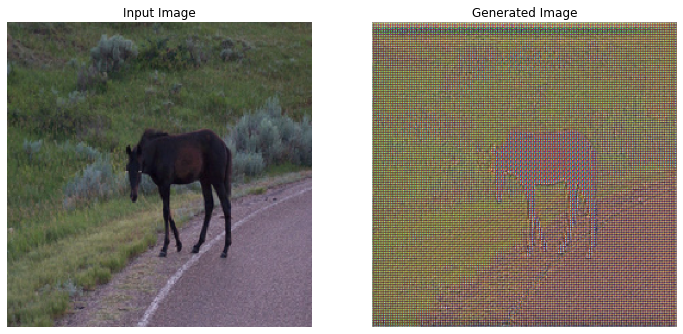

Generator F takes "zebra" to "horse"


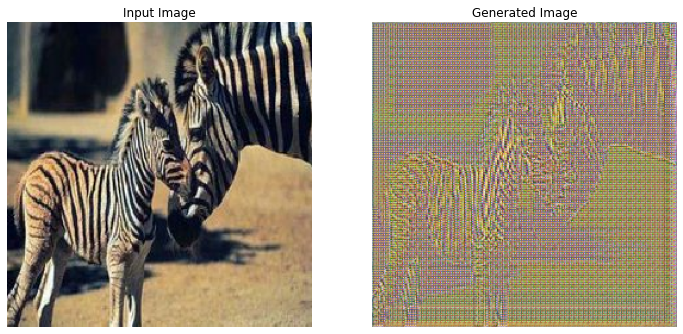

Saving checkpoint for epoch 20 at ./checkpoints/train/ckpt-4
Time taken for epoch 20 is 352.7349593639374 sec



In [29]:
# loss objects to track training loss for generator G/F, discriminator X/Y
gen_g_loss = tf.keras.metrics.Mean(name='gen_g_loss')
gen_f_loss = tf.keras.metrics.Mean(name='gen_f_loss')
disc_x_loss = tf.keras.metrics.Mean(name='disc_x_loss')
disc_y_loss = tf.keras.metrics.Mean(name='disc_y_loss')

for epoch in range(EPOCHS):
    start = time.time()

    # Each batch
    n = 0
    for image_x, image_y in tf.data.Dataset.zip((train_horses, train_zebras)):
        _gen_g_loss, _gen_f_loss, _disc_x_loss, _disc_y_loss = train_step(image_x, image_y)
        # update loss objects state
        gen_g_loss.update_state(tf.reduce_mean(_gen_g_loss))
        gen_f_loss.update_state(tf.reduce_mean(_gen_f_loss))
        disc_x_loss.update_state(tf.reduce_mean(_disc_x_loss))
        disc_y_loss.update_state(tf.reduce_mean(_disc_y_loss))
        if n % 10 == 0: print('.', end='')
        n += 1
    
    # write losses to summary
    with summary_writer.as_default():
        tf.summary.scalar(name='gen_g_loss', data=gen_g_loss.result(), step=epoch)
        tf.summary.scalar(name='gen_f_loss', data=gen_f_loss.result(), step=epoch)
        tf.summary.scalar(name='disc_x_loss', data=disc_x_loss.result(), step=epoch)
        tf.summary.scalar(name='disc_y_loss', data=disc_y_loss.result(), step=epoch)
    # reset loss objects
    gen_g_loss.reset_states()
    gen_f_loss.reset_states()
    disc_x_loss.reset_states()
    disc_y_loss.reset_states()
    
    clear_output(wait=True)
    # Using a consistent image (sample_horse) so that the progress of the model is clearly visible.
    print('Generator G takes "horse" to "zebra"')
    generate_image(generator_g, sample_horse)
    print('Generator F takes "zebra" to "horse"')
    generate_image(generator_f, sample_zebra)
    
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print('Saving checkpoint for epoch {:d} at {:s}'.format(epoch+1, ckpt_save_path))
        
    print('Time taken for epoch {:d} is {} sec\n'.format(epoch+1, time.time()-start))